In [97]:
#This is replication of web url:
# https://people.duke.edu/~ccc14/sta-663/MCMC.html#motivating-example

In [98]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [99]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial

In [100]:
np.random.seed(1234)

### Analytical solution

In [101]:
n = 100
h = 61
p = h/n
rv = st.binom(n, p)
mu = rv.mean()

In [102]:
a, b = 10, 10
prior = st.beta(a, b)
post = st.beta(h+a, n-h+b)
ci = post.interval(0.95)

In [103]:
thetas = np.linspace(0, 1, 200)

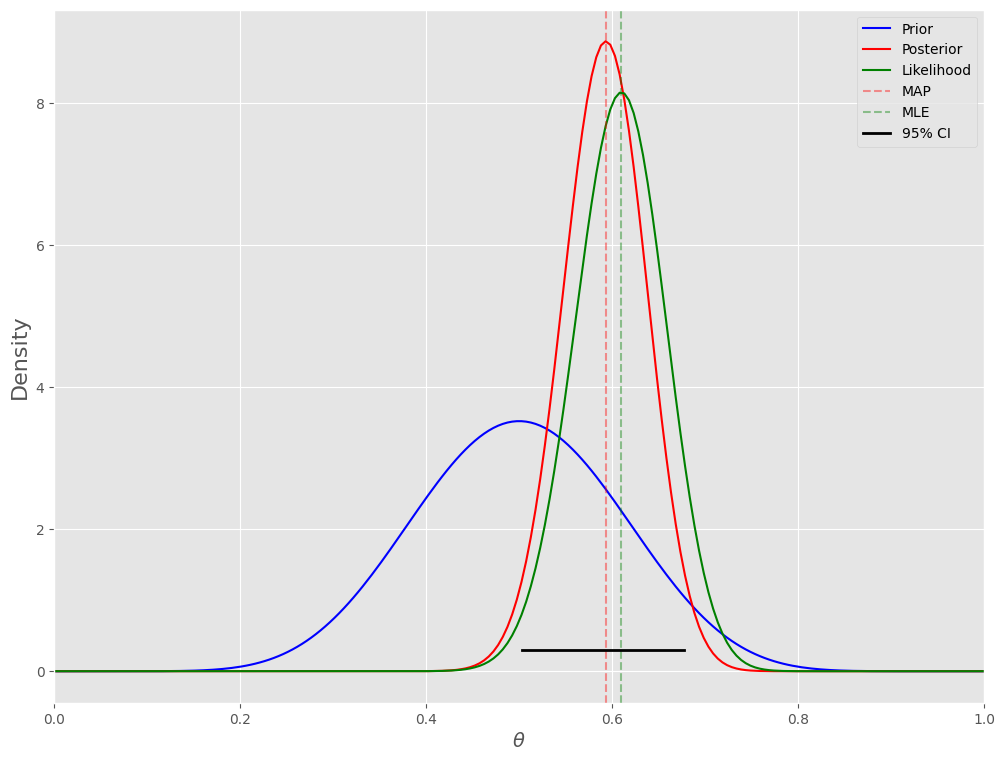

In [104]:
plt.figure(figsize=(12, 9))
plt.style.use('ggplot')
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

### Numerical integration

In [105]:
thetas = np.linspace(0, 1, 200)
prior = st.beta(a, b)

post = prior.pdf(thetas) * st.binom(n, thetas).pmf(h)

In [106]:
post /= (post.sum() / len(thetas))

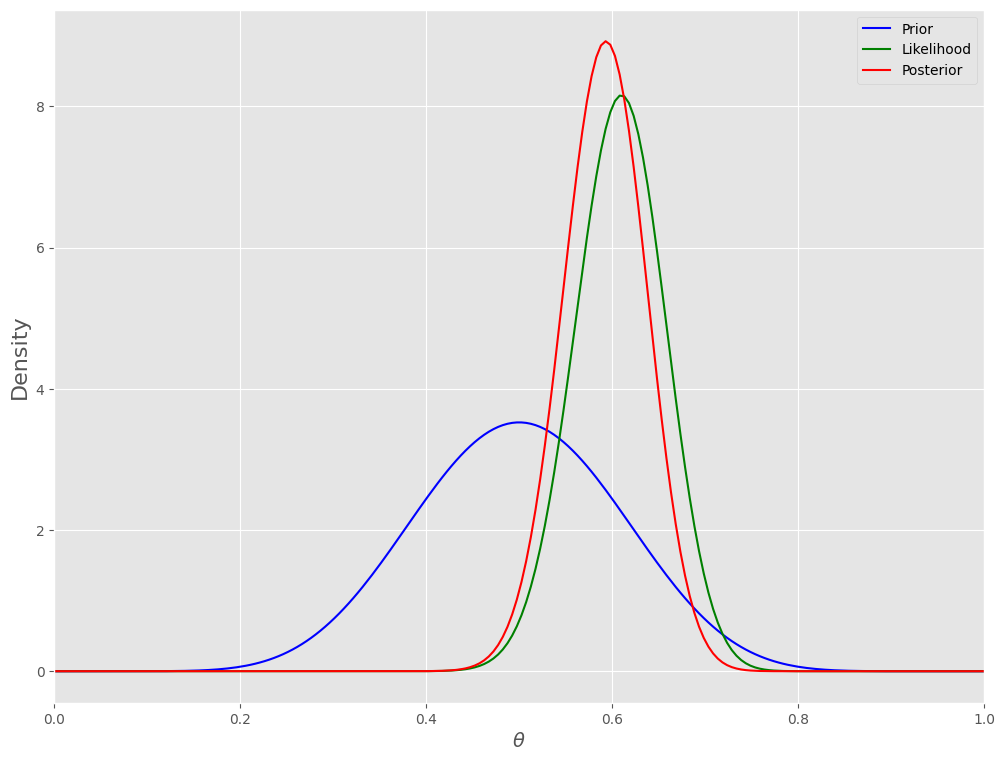

In [107]:
plt.figure(figsize=(12, 9))
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior', c='red')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

### Metropolis-Hastings sampler

In [108]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
lik = st.binom
prior = st.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    theta_p = theta + st.norm(0, sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print ("Efficiency = ", naccept/niters)

Efficiency =  0.19


In [109]:
samples

array([0.1   , 0.2414, 0.2414, ..., 0.6138, 0.6138, 0.6138])

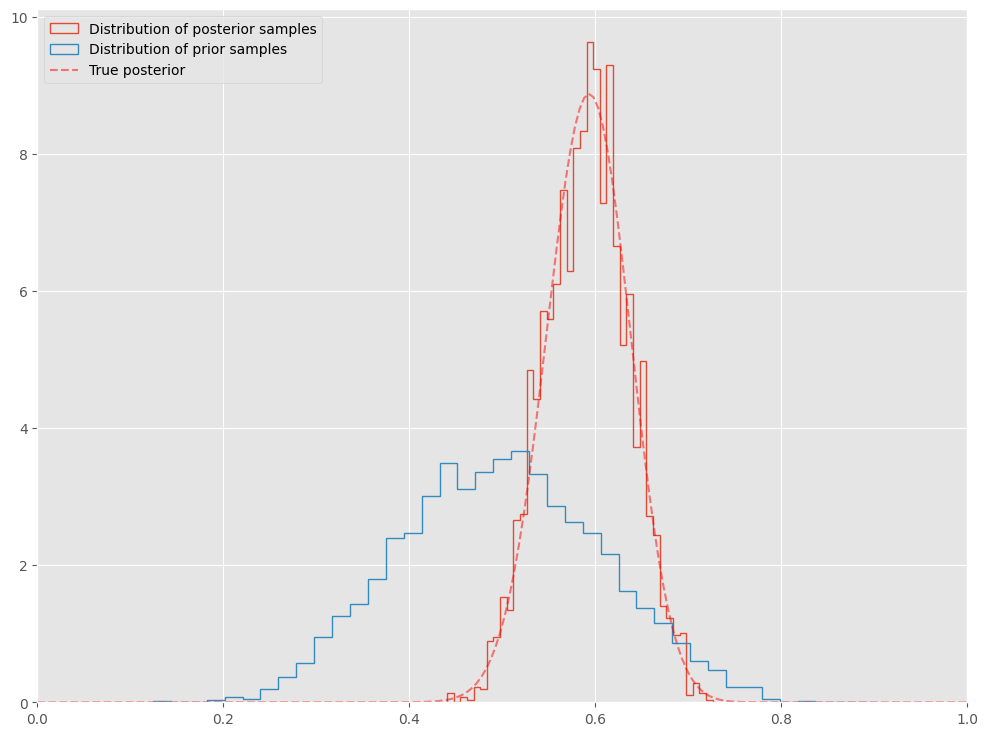

In [110]:
post = st.beta(h+a, n-h+b)

plt.figure(figsize=(12, 9))
plt.hist(samples[nmcmc:], 40, histtype='step', density=True ,linewidth=1, label='Distribution of posterior samples');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', density=True,linewidth=1, label='Distribution of prior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');

### Add Markov_Chain to Metropolistic sampler

In [111]:
def mh_coin(niters, n, h, theta, lik, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + st.norm(0, sigma).rvs()
        rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
    return samples

In [112]:
n = 100
h = 61
lik = st.binom
prior = st.beta(a, b)
sigma = 0.05
niters = 100

sampless = [mh_coin(niters, n, h, theta, lik, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

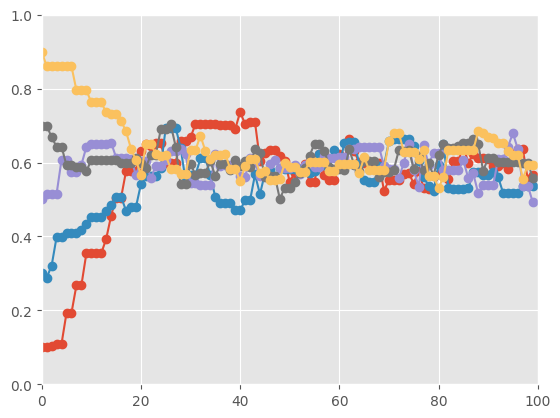

In [113]:
# Convergence of multiple chains

for samples in sampless:
    plt.plot(samples, '-o')
plt.xlim([0, niters])
plt.ylim([0, 1]);

## Gibbs sampler

In [114]:
def bern(theta, z, N):
    """Bernoulli likelihood with N trials and z successes."""
    return np.clip(theta**z * (1-theta)**(N-z), 0, 1)

In [115]:
def bern2(theta1, theta2, z1, z2, N1, N2):
    """Bernoulli likelihood with N trials and z successes."""
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)

In [116]:
def make_thetas(xmin, xmax, n):
    xs = np.linspace(xmin, xmax, n)
    widths =(xs[1:] - xs[:-1])/2.0
    thetas = xs[:-1]+ widths
    return thetas

In [157]:
from matplotlib import cm
def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection), figsize=(12,3))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.3, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
        ax[0].set_zlim(prior.min(), prior.max())
        ax[1].plot_surface(X, Y, likelihood, alpha=0.3, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
        ax[1].set_zlim(likelihood.min(), likelihood.max())
        ax[2].plot_surface(X, Y, posterior, alpha=0.3, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
        ax[2].set_zlim(posterior.min(), posterior.max())
        
    else:
        ax[0].contour(X, Y, prior)
        ax[1].contour(X, Y, likelihood)
        ax[2].contour(X, Y, posterior)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.show()

In [158]:
thetas1 = make_thetas(0, 1, 101)
thetas2 = make_thetas(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)

### Analytic solution

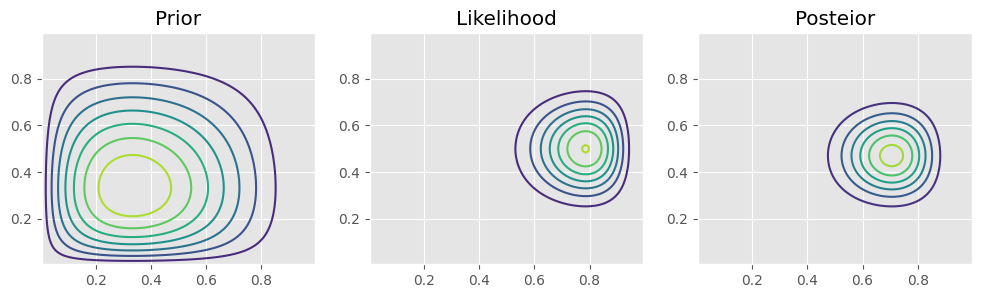

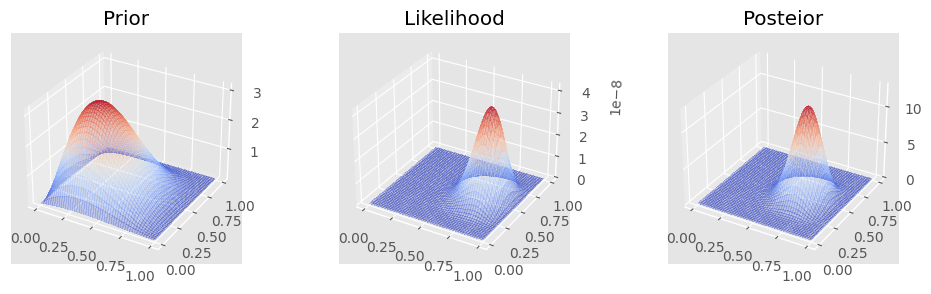

In [159]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = stats.beta(a, b).pdf(X) * stats.beta(a, b).pdf(Y)
likelihood = bern2(X, Y, z1, z2, N1, N2)
posterior = stats.beta(a + z1, b + N1 - z1).pdf(X) * stats.beta(a + z2, b + N2 - z2).pdf(Y)
make_plots(X, Y, prior, likelihood, posterior)
make_plots(X, Y, prior, likelihood, posterior, projection='3d')

### Grid approximation

In [160]:
def c2d(thetas1, thetas2, pdf):
    width1 = thetas1[1] - thetas1[0]
    width2 = thetas2[1] - thetas2[0]
    area = width1 * width2
    pmf = pdf * area
    pmf /= pmf.sum()
    return pmf

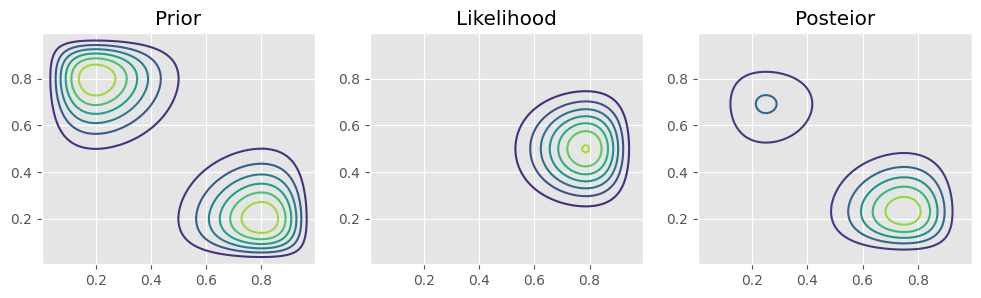

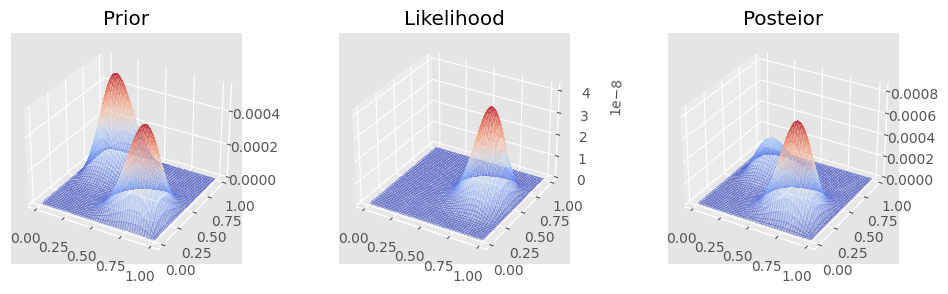

In [161]:
_prior = bern2(X, Y, 2, 8, 10, 10) + bern2(X, Y, 8, 2, 10, 10)
prior_grid = c2d(thetas1, thetas2, _prior)
_likelihood = bern2(X, Y, 1, 1, 2, 3)
posterior_grid = _likelihood * prior_grid
posterior_grid /= posterior_grid.sum()
make_plots(X, Y, prior_grid, likelihood, posterior_grid)
make_plots(X, Y, prior_grid, likelihood, posterior_grid, projection='3d')

#### Metropolis

In [162]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([0.2,0.2])

thetas = np.zeros((niters-burnin, 2), np.float)
for i in range(niters):
    new_theta = stats.multivariate_normal(theta, sigma).rvs()
    p = min(target(*new_theta)/target(*theta), 1)
    if np.random.rand() < p:
        theta = new_theta
    if i >= burnin:
        thetas[i-burnin] = theta

C:\Users\abyo0503\AppData\Local\Temp\ipykernel_9228\2930333595.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  thetas = np.zeros((niters-burnin, 2), np.float)


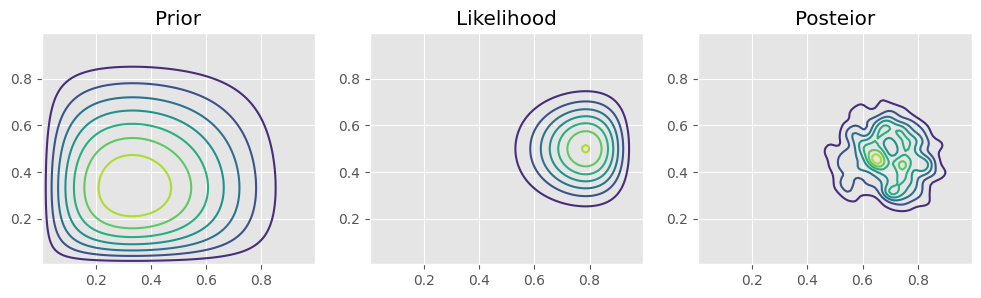

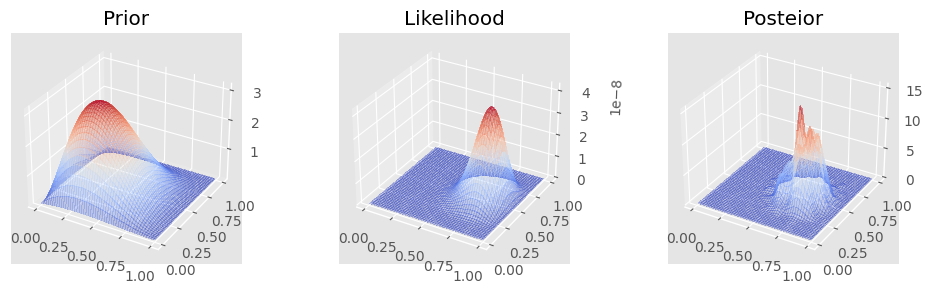

In [163]:
kde = stats.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_metroplis = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis, projection='3d')

#### Gibbs

In [167]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([0.2,0.2])

In [170]:
thetas = np.zeros((niters-burnin,2), np.float)
for i in range(niters):
    theta = [stats.beta(a + z1, b + N1 - z1).rvs(), theta[1]]
    theta = [theta[0], stats.beta(a + z2, b + N2 - z2).rvs()]

    if i >= burnin:
        thetas[i-burnin] = theta

C:\Users\abyo0503\AppData\Local\Temp\ipykernel_9228\891063376.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  thetas = np.zeros((niters-burnin,2), np.float)


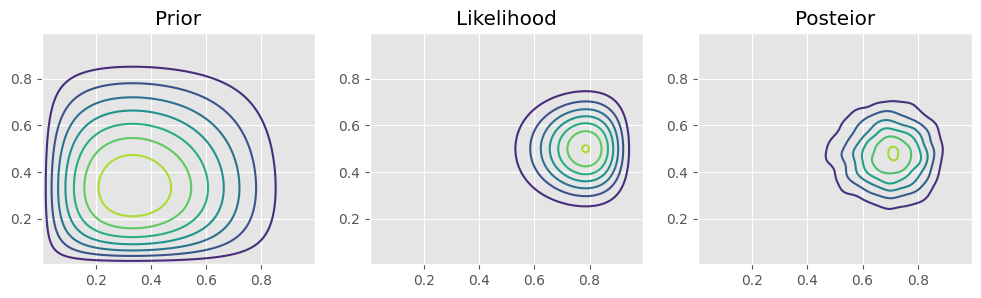

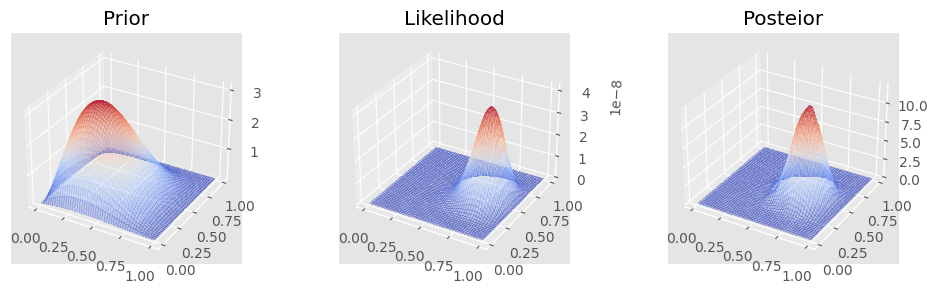

In [171]:
kde = stats.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_gibbs = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs, projection='3d')